# Sparse GP Classification (On Toy dataset)

## Model Description

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$f \sim\mathcal{GP}_{\text{FITC}}(K, z_{1:M})$
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$Y_n \sim \mathrm{Bernoulli}(\sigma(f))$,

where $K(x_1,x_2) = \exp\left(\beta - \sum_{d=1,2}\mathrm{softplus}({\alpha_d})\cdot(x_{1d} - x_{2d})^2\right)$.
<br>
Here, latent process $f\sim\mathcal{GP}_{\text{FITC}}(K, z_{1:M})$ is defined as:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$u=f_0\small{(z_{1:M})}$ for $f_0\sim\mathcal{GP}(K)$
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$f(x)\sim\mathcal{GP}(K| f\small{(z_{1:M})}=u)$ <br>
Additionally, conditional independence of process $f$ among any points given $u=f_0\small{(z_{1:M})} = \left(f_0(z_1), ..., f_0(z_M)\right)$ is assumed. <br>
That is, for any $n_1$ and $n_2$, $f(x_{n_1})\perp \!\!\! \perp f(x_{n_1})|u$.

## Local Marginalization of Evidece Lower Bound
By simplifying notation as $f_{1:N} = f(x_{1:N})$ and $u = f(z_{1:M})$, we can write evidence lower bound (ELBO) and locally margianlized likelihood (LM-ELBO).

\begin{align}
\mathrm{LM}\text{-}\mathrm{ELBO}
&= \log p(y_{1:N}) - \mathrm{KL}\left[\ q(u)\ ||\ p(u|y_{1:N})\ \right] \\
&= \mathrm{E}_{u\sim q}\left[\ \log p(y_{1:N}|u)\ \right]
 - \mathrm{KL}\left[\ q(u)\ ||\ p(u)\ \right] \\
&\geq \mathrm{E}_{u\sim q}\left[\ \log p(y_{1:N}|u)
- \mathrm{KL}\left[\ p(f_{1:N}|u)\ ||\ p(f_{1:N}| y_{1:N}, u)\ \right]\ \right]
 - \mathrm{KL}\left[\ q(u)\ ||\ p(u)\ \right] \\
&= \log p(y_{1:N}) - \mathrm{KL}\left[ p(f_{1:N}|u)q(u) || p(y_{1:N}, f_{1:N}, u) \right]\\
&= \mathrm{E}_{u\sim q} \mathrm{E}_{f_{1:N}\sim p(f_{1:N}|u)}\left[
\log \left(\frac{p(y_{1:N}, f_{1:N}, u)}{p(f_{1:N}| u)q(u)}\right) 
\right] \\
&= \sum_{n=1}^N\mathrm{E}_{u\sim q} \mathrm{E}_{f_n\sim p(f_n|u)}
\left[ \log p(y_n| f_n) \right] 
- \mathrm{KL}\left[\ q(u)\ ||\ p(u)\ \right] \\
&= \mathrm{ELBO}
\end{align}

### Possible Datasets
- http://archive.ics.uci.edu/ml/datasets/Adult
- http://archive.ics.uci.edu/ml/datasets/Bar+Crawl%3A+Detecting+Heavy+Drinking
- http://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008
- http://archive.ics.uci.edu/ml/datasets/Buzz+in+social+media+

## Import Packages

In [1]:
# Turn GPUs off
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, norm
import matplotlib
from matplotlib import pyplot as plt
import time
import datetime
np.random.seed(0)

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

## Utilities

In [45]:
sigmoid = lambda x: 1/(1+np.exp(-x))
softplus = lambda x: np.log(1+np.exp(x))
as_tf_float = lambda x: tf.cast(x, tf.float64)

def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

def timestamp():
    now = datetime.datetime.now()
    return now.strftime("%Y%m%d%H%M%S")  

## Generate Toy Dataset

In [46]:
N = 1000
D = 10
M = 30

In [47]:
# Paramters
b0 = np.float64(0.)
b  = np.random.randn(D) / np.sqrt(D)

In [48]:
# We assume that we have infinite amount of data.
# Thus, generator of the data is implemented.
def generate_data(N, D, b0, b):
    """
    Genarate N samples of data from the model with parameter [beta0, beta, alpha]. 
    Returns:
    x: 3-d array of size [N, D]
    y: 2-d array of size [N]
    """
    x = np.random.randn(N*D).reshape([N,D])
    logit = lambda x: (b0+x@b).reshape([N])
    y = bernoulli(p=sigmoid(logit(x))).rvs()
    y = np.reshape(y, [N])
    return x,y, logit

In [54]:
def init_param(D, M):
    theta = {
    'z': tf.Variable(2.*np.random.randn(M*D).reshape([M,D])),
    'alpha': tf.Variable(np.ones([D]), dtype=tf.float64),
    'beta': tf.Variable(1., dtype=tf.float64)
    }
    phi = {
        'm': tf.Variable(np.zeros([M]), dtype=tf.float64),
        'CholS': tf.Variable(np.eye(M), dtype=tf.float64)
    }
    return theta, phi

In [50]:
def get_K(alpha, beta):
    # define Kernel
    D = alpha.shape[0]
    sp_alpha = tf.reshape( tf.math.softplus( alpha ), [1,1,D])
    def K(x1,x2):
        n1 = x1.shape[0]
        n2 = x2.shape[0]
        x1 = tf.reshape(x1, [n1, 1, D])
        x2 = tf.reshape(x2, [1 ,n2, D])
        return tf.exp(beta - tf.reduce_sum( sp_alpha*(x1-x2)**2, axis=2))
    return K

In [10]:
theta, phi = init_param(D,M)

In [11]:
x,y,logit = generate_data(N, D, b0, b)

likelihood = np.mean(y*np.log(sigmoid(logit(x))) + (1-y)*np.log(1-sigmoid(logit(x))))
print('test_likelihood: {}'.format( likelihood ) )    

test_likelihood: -0.5586463571561856


## ELBO

In [12]:
def ELBO(x, y, theta, phi, N_total):
    '''
    Inputs:
    x: 2-d array of shape [N,D]
    y: 1-d array of shape [N]
    theta: disctionary of model parameters
    phi: disctionary of variational parameters
    
    Returns:
    elbo: scalar
    '''
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    CholS = phi['CholS']
    
    # sample u = f_0(z_1,...,z_M) from q
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    u = q_u.sample(N)
    
    
    # sample f conditionally given u = f_0(z_1,...,z_M)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    f = q_f.sample()

    # compute ELBO estimate
    p_y = tfp.distributions.Bernoulli(logits=f)
    kl_qu_pu = tfp.distributions.kl_divergence(q_u, p_u)
    elbo = tf.reduce_mean(p_y.log_prob(y)) - kl_qu_pu / N_total
    return elbo

In [13]:
def LMELBO(x, y, theta, phi, N_total, n_MC):
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    CholS = phi['CholS']
    
    # sample u = f_0(z_1,...,z_M) from q
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    u = q_u.sample(N)
    
    
    # sample f conditionally given u = f_0(z_1,...,z_M)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    f = q_f.sample(n_MC)

    # compute LMELBO estimate
    p_y = tfp.distributions.Bernoulli(logits=f)
    log_prob_y = tf.reduce_mean( tf_logmeanexp( p_y.log_prob(y) , axis=0) ) 
    kl_qu_pu = tfp.distributions.kl_divergence(q_u, p_u)
    lmelbo = log_prob_y - kl_qu_pu / N_total
    return lmelbo

In [14]:
def pointwise_dconditional_likelihood(x, y, theta, phi, level):
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    CholS = phi['CholS']
    
    # sample u = f_0(z_1,...,z_M) from q
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    u = q_u.sample(N)
    
    # sample f conditionally given u = f_0(z_1,...,z_M)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    n_MC = 2**level
    f = q_f.sample(n_MC)

    # compute ELBO estimate
    p_y = tfp.distributions.Bernoulli(logits=f)
    w = p_y.log_prob(y)
    w = tf.reshape(w, [n_MC,N])
    if level==0:
        return tf_logmeanexp(w, axis=0) 
    else:
        return tf_logmeanexp(w, axis=0)\
                - (1/2.) * tf_logmeanexp(w[:n_MC//2 ], axis=0)\
                - (1/2.) * tf_logmeanexp(w[ n_MC//2:], axis=0)

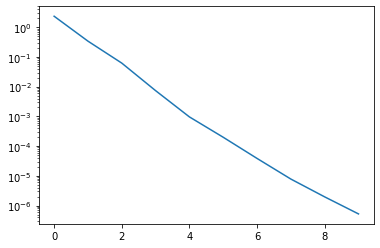

In [15]:
var_dcond_L = lambda l: pointwise_dconditional_likelihood(x, y, theta, phi, level=l).numpy().var()
plt.plot([var_dcond_L(l) for l in range(10)])
plt.yscale('log')

In [16]:
def dconditional_likelihood(x, y, mean_f, var_f, level):
    
    N = y.shape[0]
    # sample f_n's
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    n_MC = 2**level
    f = q_f.sample(n_MC)
    
    # sample conditional likelihoods
    p_y = tfp.distributions.Bernoulli(logits=f)
    w = p_y.log_prob(y)
    w = tf.reshape(w, [n_MC,N])
    
    if level==0:
        dL = tf_logmeanexp(w, axis=0) 
    else:
        dL = tf_logmeanexp(w, axis=0)\
                - (1/2.) * tf_logmeanexp(w[:n_MC//2 ], axis=0)\
                - (1/2.) * tf_logmeanexp(w[ n_MC//2:], axis=0)
    return tf.reduce_mean( dL )

In [17]:
def LMELBO_MLMC(x, y, theta, phi, N_total, max_level=8, w0=1-2.**(-3/2), b=2, randomize=False):
    """
    Compute IWELBO by MLMC
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
    max_level: integer
    w0: the proportion of total samples in (x,y) used at the level 0.
        in other words, 100*(1-w0) % of the total samples are used for estimating the correction term.
    b: scalar. the second moment of the coupled difference estimator (dIWELBO) must decrease at a rate of O(2^(-b*level)).
    randomize: whether to use randomization of MLMC.
    
    Returns:
    iwelbo: scalar estimate of average iwelbo over sample points.
    """
    # unpack parameters
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    CholS = phi['CholS']
    
    # calculate KL divergence of p(u) and q(u) of u = f_0(z_1,...,z_M)
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    kl_qu_pu = tfp.distributions.kl_divergence(q_u, p_u)
      
    # calculate distribution of f conditionally on u = f_0(z_1,...,z_M)
    u = q_u.sample(N)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    # determine proportions of the number of samples among levels
    if max_level==0:
        levels = np.array([0])
        weights = np.array([1.])
    else:
        weights = 2.**(-(b+1)/2*np.arange(max_level))
        weights /= sum(weights)
        weights = np.concatenate([[w0], (1-w0)*weights])
        levels = np.arange(max_level+1)
    
    # determine the N_l's
    if randomize==True:
        Ns = np.random.multinomial(n=N, pvals=weights)    
    elif randomize==False:
        Ns = np.array([np.math.ceil(w*N) for w in weights], dtype=np.int)
        Ns[0] = N - sum(Ns[1:])
    else:
        raise(Exception("Invarid argument for 'randomize' of function IWELBO_MLMC. It must be True or False."))
    
    # compute dIWELBO's using disjoint samples at each level and sum them up
    offset = 0
    lmelbo = kl_qu_pu / N_total
    for i, l in enumerate(levels):
        if Ns[i]==0:
            continue
        x_tmp = x[offset:offset+Ns[i]]
        y_tmp = y[offset:offset+Ns[i]]
        mean_f_tmp = mean_f[offset:offset+Ns[i]]
        var_f_tmp = var_f[offset:offset+Ns[i]]
                       
        if randomize==True:
            lmelbo += dconditional_likelihood(x_tmp, y_tmp, mean_f_tmp, var_f_tmp, level=l) * Ns[i] / N / weights[i]   
        elif randomize==False:
            lmelbo += dconditional_likelihood(x_tmp, y_tmp, mean_f_tmp, var_f_tmp, level=l)
    
        offset += Ns[i]
          
    return lmelbo

In [18]:
theta, phi = init_param(D, M)

In [24]:
optimizer = tf.keras.optimizers.Adam(0.05)

losses = []
for t in range(401):
    x,y,_ = generate_data(N, D, b0, b)

    with tf.GradientTape() as g:
        g.watch([theta, phi])
        loss = - ELBO(x, y, theta, phi, 40000)
    dtheta, dphi = g.gradient(loss, [theta, phi])
    
    gradients = list(dtheta.values()) + list(dphi.values())
    variables = list(theta.values()) + list(phi.values())
    optimizer.apply_gradients(zip(gradients, variables))
    
    losses.append(loss.numpy())
    if t%20==19:
        print('#iter: {}-{}\t{}'.format(t-19,t, np.mean(losses)))
        losses = []

#iter: 0-19	1.0233973737465296
#iter: 20-39	0.7795630044380056
#iter: 40-59	0.7304450452491353
#iter: 60-79	0.7158655762301155
#iter: 80-99	0.7109668472134784
#iter: 100-119	0.7052441786491701
#iter: 120-139	0.7010899485379822
#iter: 140-159	0.6492577319328683
#iter: 160-179	0.5932396098034849
#iter: 180-199	0.5883178076480846
#iter: 200-219	0.5837588467574177
#iter: 220-239	0.5827245690924876
#iter: 240-259	0.5832021887980583
#iter: 260-279	0.5845713707335128
#iter: 280-299	0.5768273161233404
#iter: 300-319	0.5783589226611902
#iter: 320-339	0.5765869219264509
#iter: 340-359	0.5749911953944069
#iter: 360-379	0.5729502452406581
#iter: 380-399	0.5728062044091426


In [42]:
optimizer = tf.keras.optimizers.SGD(0.001)

losses = []
for t in range(401):
    x,y,_ = generate_data(N, D, b0, b)

    with tf.GradientTape() as g:
        g.watch([theta, phi])
        loss = - LMELBO(x, y, theta, phi, 40000, n_MC=512)
    dtheta, dphi = g.gradient(loss, [theta, phi])
    
    gradients = list(dtheta.values()) + list(dphi.values())
    variables = list(theta.values()) + list(phi.values())
    optimizer.apply_gradients(zip(gradients, variables))
    
    losses.append(loss.numpy())
    if t%20==19:
        print('#iter: {}-{}\t{}'.format(t-19,t, np.mean(losses)))
        losses = []

#iter: 0-19	0.5717669341440976
#iter: 20-39	0.5733134123915106
#iter: 40-59	0.5705471602092815
#iter: 60-79	0.5692226711485961
#iter: 80-99	0.5689404211890854
#iter: 100-119	0.5662340493727335
#iter: 120-139	0.5752188638094785
#iter: 140-159	0.5683813467083699
#iter: 160-179	0.5707087305455907
#iter: 180-199	0.5710795646684903
#iter: 200-219	0.5739845298507148
#iter: 220-239	0.5651183834132241
#iter: 240-259	0.5676512272681203
#iter: 260-279	0.5733322943794763
#iter: 280-299	0.5697475846853143
#iter: 300-319	0.5694210693567914
#iter: 320-339	0.5638314441704704
#iter: 340-359	0.5717083719095889
#iter: 360-379	0.5654339055506082
#iter: 380-399	0.5730472231067


In [25]:
np.var([ELBO(x, y, theta, phi, N_total=10000) for x,y,_ in [generate_data(N, D, b0, b) for i in range(100)]])

0.0001697766302706839

In [26]:
np.var([LMELBO(x, y, theta, phi, N_total=10000, n_MC=2**10) for x,y,_ in [generate_data(N, D, b0, b) for i in range(100)]])

0.00019745998198914168

In [27]:
np.var([LMELBO_MLMC(x, y, theta, phi, N_total=10000, max_level=10) for x,y,_ in [generate_data(N, D, b0, b) for i in range(100)]])

0.00037614723366216884

In [46]:
np.mean([ELBO(x, y, theta, phi, N_total=10000) for x,y,_ in [generate_data(N, D, b0, b) for i in range(10)]])

-0.5867034079861775

In [47]:
np.mean([LMELBO(x, y, theta, phi, N_total=10000, n_MC=2**10) for x,y,_ in [generate_data(N, D, b0, b) for i in range(10)]])

-0.566057397680685

In [48]:
np.mean([LMELBO_MLMC(x, y, theta, phi, N_total=10000, max_level=10) for x,y,_ in [generate_data(N, D, b0, b) for i in range(10)]])

-0.5626269070025722

In [31]:
x,y,logit = generate_data(100000, D, b0, b)

likelihood = np.mean(y*np.log(sigmoid(logit(x))) + (1-y)*np.log(1-sigmoid(logit(x))))
print('test_likelihood: {}'.format( likelihood ) )    

test_likelihood: -0.5676172448577175


In [32]:
%%timeit
ELBO(x, y, theta, phi, N_total=10000)

280 ms ± 3.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%%timeit
LMELBO(x, y, theta, phi, N_total=10000, n_MC=2**10)

4.13 s ± 165 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%%timeit
LMELBO_MLMC(x, y, theta, phi, N_total=10000, max_level=10, randomize=True)

336 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Parameter Estimation

In [123]:
theta, phi = init_param(D, M)

In [124]:
optimizer = tf.keras.optimizers.Adam(0.05)

losses = []
for t in range(401):
    x,y,_ = generate_data(N, D, b0, b)

    with tf.GradientTape() as g:
        g.watch([theta, phi])
        loss = - ELBO(x, y, theta, phi, 40000)
    dtheta, dphi = g.gradient(loss, [theta, phi])
    
    gradients = list(dtheta.values()) + list(dphi.values())
    variables = list(theta.values()) + list(phi.values())
    optimizer.apply_gradients(zip(gradients, variables))
    
    losses.append(loss.numpy())
    if t%20==19:
        print('#iter: {}-{}\t{}'.format(t-19,t, np.mean(losses)))
        losses = []

#iter: 0-19	1.018710070237884
#iter: 20-39	0.773073031847605
#iter: 40-59	0.7289769968597667
#iter: 60-79	0.7155409761835736
#iter: 80-99	0.7066893741677387
#iter: 100-119	0.6369082341803793
#iter: 120-139	0.5908767362977156
#iter: 140-159	0.5863431592988616
#iter: 160-179	0.5767914242224543
#iter: 180-199	0.5821507376086883
#iter: 200-219	0.577908948588589
#iter: 220-239	0.5806179545297194
#iter: 240-259	0.5761532032127914
#iter: 260-279	0.5726980632952504
#iter: 280-299	0.5737477040279211
#iter: 300-319	0.5739096294220614
#iter: 320-339	0.5836058236946312
#iter: 340-359	0.5739776099685409
#iter: 360-379	0.5744089673336343
#iter: 380-399	0.5688255233926489


In [125]:
theta, phi = init_param(D, M)

In [126]:
optimizer = tf.keras.optimizers.Adam(0.05)

losses = []
for t in range(401):
    x,y,_ = generate_data(N, D, b0, b)

    with tf.GradientTape() as g:
        g.watch([theta, phi])
        loss = - LMELBO(x, y, theta, phi, 40000, n_MC=64)
    dtheta, dphi = g.gradient(loss, [theta, phi])
    
    gradients = list(dtheta.values()) + list(dphi.values())
    variables = list(theta.values()) + list(phi.values())
    optimizer.apply_gradients(zip(gradients, variables))
    
    losses.append(loss.numpy())
    if t%20==19:
        print('#iter: {}-{}\t{}'.format(t-19,t, np.mean(losses)))
        losses = []

#iter: 0-19	0.6957926142057649
#iter: 20-39	0.6943251986199738
#iter: 40-59	0.6932672847201165
#iter: 60-79	0.6929880734820955
#iter: 80-99	0.6933136549594463
#iter: 100-119	0.685058562371937
#iter: 120-139	0.6090975214685137
#iter: 140-159	0.5827406616955532
#iter: 160-179	0.5832850474594143
#iter: 180-199	0.571913427216558
#iter: 200-219	0.5792077989702952
#iter: 220-239	0.5749212510247153
#iter: 240-259	0.5791959878578709
#iter: 260-279	0.5743867340787278
#iter: 280-299	0.5784488910472982
#iter: 300-319	0.5762827383392162
#iter: 320-339	0.5738592202424055
#iter: 340-359	0.572440713353842
#iter: 360-379	0.5784565077568601
#iter: 380-399	0.5824527096459136


## Visualize Prediction

In [42]:
def get_logits(x, theta, phi):
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    m = phi['m']
    CholS = phi['CholS']

    N = x.shape[0]
    M = z.shape[0]
    
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,j->n', K_nm, inv_K_mm, m)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    return mean_f, var_f

In [43]:
def heatmap2d(arr: np.ndarray, cmap='viridis'):
    plt.imshow(arr, cmap=cmap, extent=[-6,6,-6,6],origin='lower', alpha=1, vmin=0, vmax=1)
    plt.colorbar()
    #plt.show()

In [27]:
x1_heat = (np.linspace(start=-6,stop=6).reshape([1,50])*np.ones([50,1])).reshape([2500])
x2_heat = np.repeat(np.linspace(start=-6,stop=6), 50)
x_heat = np.array([x1_heat, x2_heat]).T
logits_heat = get_logits(x_heat, theta, phi)[0].numpy()

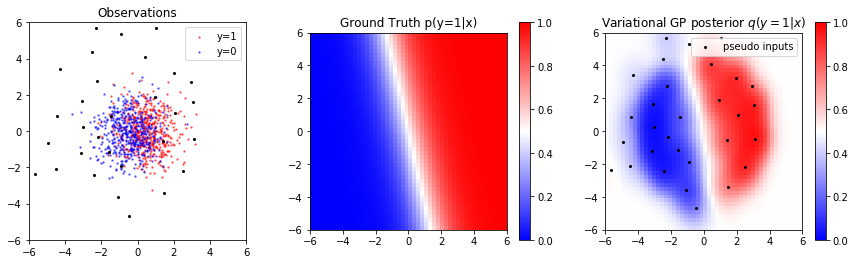

In [28]:
plt.figure(figsize=[15,4])
cmap = matplotlib.cm.get_cmap('bwr')#('viridis')

plt.subplot(1,3,1)
plt.title('Observations')
idx = (y==True)
plt.scatter(x[idx,0], x[idx,1], s=2, alpha=0.5, marker='o', c=[cmap(1.)])
plt.scatter(x[~idx,0], x[~idx,1], s=2, alpha=0.5, marker='o', c=[cmap(0.)])
plt.scatter(theta['z'][:,0], theta['z'][:,1], s=4, alpha=1, marker='o', c='black')
plt.legend(['y=1','y=0'])
plt.xlim([-6,6])
plt.ylim([-6,6])
ax = plt.gca()
ax.set_aspect('equal')

plt.subplot(1,3,2)
plt.title('Ground Truth p(y=1|x)')
heatmap2d(sigmoid(logit(x_heat)).reshape([50,50]), 'bwr')

plt.subplot(1,3,3)
plt.title(r'Variational GP posterior $q(y=1|x)$')
#plt.scatter(x[idx,0], x[idx,1], s=0.3, alpha=1, marker='x', c=[cmap(1.)])
#plt.scatter(x[~idx,0], x[~idx,1], s=0.3, alpha=1, marker='x', c=[cmap(0.)])
a = plt.scatter(theta['z'][:,0], theta['z'][:,1], s=4, alpha=1, marker='o', c='black')
plt.legend([a],['pseudo inputs'])
heatmap2d(sigmoid(logits_heat.reshape([50,50])), 'bwr')

## Learning Curve by Different Methods

In [ ]:
lambda x1, x2 = (gamma * tf.reduce_sum(x1*x2) + coef0)^degree


・Test LMELBO をプロットしないと意味ない<br>
・<s>MNISTで、バッチサイズ小さめで検証</s>←カーネルの計算が重いと死ぬ<br>
・潜在変数のサンプルは$\mathcal{O}(1)$。各データ点の処理は$\mathcal{O}(M^2)$という致命的な問題がある。<br>
・MLMCは潜在変数のサンプリングコストが支配的なときに使うもの。<br>
・かと言って、潜在変数の空間が複雑だと、カップリングしないという問題もある。

結論…$M$を固定して、Small Dataでなんとか頑張って優位性を示す

In [29]:
def get_mlmc_cost(N, max_level, b, w0):
    # compute the cost of MLMC estimation 
    # when the size of x (and that of y) is N
    if max_level==0:
        levels = np.array([0])
        weights = np.array([1.])
    else:
        weights = 2.**(-(b+1)/2*np.arange(max_level))
        weights /= sum(weights)
        weights = np.concatenate([[w0], (1-w0)*weights])
        levels = np.arange(max_level+1)
    cost = np.ceil(N * weights[0])\
            + N * sum( np.ceil(weights[1:] * (2**levels[1:] + 2**(levels[1:]-1))) )
    return cost

In [32]:
objectives = {
    "elbo":      lambda x, y, theta, phi: ELBO(x, y, theta, phi, N_total=40000),
    "lmelbo8":   lambda x, y, theta, phi: LMELBO(x, y, theta, phi, N_total=40000, n_MC=8),
    "lmelbo64":  lambda x, y, theta, phi: LMELBO(x, y, theta, phi, N_total=40000, n_MC=64),
    "lmelbo512": lambda x, y, theta, phi: LMELBO(x, y, theta, phi, N_total=40000, n_MC=512),
    "lmelbo512_mlmc": lambda x, y, theta, phi: LMELBO(x, y, theta, phi, N_total=40000, n_MC=512),
    "lmelbo512_randmlmc": lambda x, y, theta, phi: LMELBO(x, y, theta, phi, N_total=40000, n_MC=512),
}

n_repeat = 10
results = {}

for name, obj in objectives.items():
    loss_seqs = []
    for i in range(n_repeat):
        print("training {}.... #iter:{} ".format(name,i))
        optimizer = tf.keras.optimizers.Adam(0.05)
        theta, phi = init_param(D,M)
        loss_seq = []
        
        for t in range(400):
            x,y,_ = generate_data(N, D, b0, b)

            # balance the cost of mlmc and nmc when level=9 (n_MC=512)
            if 'mlmc' in name:
                cost_nmc  = N * 2**9
                cost_mlmc = get_mlmc_cost(N, max_level=9, b=1.8, w0=0.9)
                N_mlmc = np.math.ceil(N * (cost_nmc / cost_mlmc))
                x,y,_ = generate_data(N_mlmc, D, b0, b)
            
            # Optimize
            with tf.GradientTape() as g:
                g.watch([theta, phi])
                loss = - obj(x, y, theta, phi)
            dtheta, dphi = g.gradient(loss, [theta, phi])
            gradients = list(dtheta.values()) + list(dphi.values())
            variables = list(theta.values()) + list(phi.values())
            optimizer.apply_gradients(zip(gradients, variables))

            loss_seq.append(loss.numpy())
        loss_seqs.append(loss_seq) 
    results[name] = np.array(loss_seqs)
    print()

training elbo.... #iter:0 
training elbo.... #iter:1 
training elbo.... #iter:2 
training elbo.... #iter:3 
training elbo.... #iter:4 
training elbo.... #iter:5 
training elbo.... #iter:6 
training elbo.... #iter:7 
training elbo.... #iter:8 
training elbo.... #iter:9 

training lmelbo8.... #iter:0 
training lmelbo8.... #iter:1 
training lmelbo8.... #iter:2 
training lmelbo8.... #iter:3 
training lmelbo8.... #iter:4 
training lmelbo8.... #iter:5 
training lmelbo8.... #iter:6 
training lmelbo8.... #iter:7 
training lmelbo8.... #iter:8 
training lmelbo8.... #iter:9 

training lmelbo64.... #iter:0 
training lmelbo64.... #iter:1 
training lmelbo64.... #iter:2 
training lmelbo64.... #iter:3 
training lmelbo64.... #iter:4 
training lmelbo64.... #iter:5 
training lmelbo64.... #iter:6 
training lmelbo64.... #iter:7 
training lmelbo64.... #iter:8 
training lmelbo64.... #iter:9 

training lmelbo512.... #iter:0 
training lmelbo512.... #iter:1 
training lmelbo512.... #iter:2 
training lmelbo512...

In [34]:
import pickle

In [37]:
#with open('../out/gaussian_process_classification/train_log_{}.pickel'.format(timestamp()), 'wb') as file:
#    pickle.dump(results, file)

(0.54, 0.66)

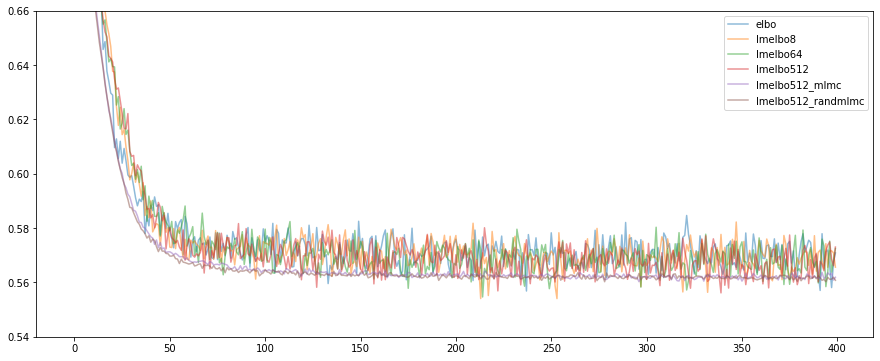

In [57]:
plt.figure(figsize=[15,6])
for logs in results.values():
    plt.plot(logs.mean(axis=0), alpha=0.5)
plt.legend([name for name in results])
plt.ylim([0.54, 0.66])